In [1]:
import torch
from torch.nn import functional as F
from matplotlib import pyplot as plt
import random

In [2]:
DEV = "cuda:0" if torch.cuda.is_available() else "cpu"
DEV = torch.device(DEV)
DEV

device(type='cuda', index=0)

## Load data

In [3]:
!wget https://raw.githubusercontent.com/ncarkaci/TDKDictionaryCrawler/master/ortak_kelimeler.txt

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
with open("ortak_kelimeler.txt", encoding='utf-8') as f:
    text = f.read()

In [5]:
words = text.split("\n")

In [6]:
long_text = text.replace("\n","")
ids = list(set(long_text))
len(ids)

29

In [7]:
ordinal_char_pairs = sorted([(ord(c),c) for c in ids])
ordinal_char_pairs

[(97, 'a'),
 (98, 'b'),
 (99, 'c'),
 (100, 'd'),
 (101, 'e'),
 (102, 'f'),
 (103, 'g'),
 (104, 'h'),
 (105, 'i'),
 (106, 'j'),
 (107, 'k'),
 (108, 'l'),
 (109, 'm'),
 (110, 'n'),
 (111, 'o'),
 (112, 'p'),
 (114, 'r'),
 (115, 's'),
 (116, 't'),
 (117, 'u'),
 (118, 'v'),
 (121, 'y'),
 (122, 'z'),
 (231, 'ç'),
 (246, 'ö'),
 (252, 'ü'),
 (287, 'ğ'),
 (305, 'ı'),
 (351, 'ş')]

In [8]:
len(ordinal_char_pairs)

29

## Encode & Decode Functions

In [9]:
ctoi = {c:i for i,(o,c) in enumerate(ordinal_char_pairs)}
itoc =  {i:c for i,(o,c) in enumerate(ordinal_char_pairs)}

In [10]:
ctoi['.']=len(ctoi)
itoc[len(itoc)]='.'

In [11]:
def encode(input:str):
    return [ctoi[c] for c in input]

def decode(ids):
    return "".join([itoc[i] for i in ids])

In [12]:
assert decode(encode("zemberek"))=='zemberek'

## Helpers

In [13]:
def plot_training_loss(nn):
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))


    axs[0].plot(nn.losses, label="Neural net train loss")
    axs[0].plot(nn.val_losses, label="Neural net val loss")
    axs[0].set_title('Losses')
    axs[0].legend()

    axs[1].plot([g[1] for g in nn.grads], label="Max")
    axs[1].plot([g[0] for g in nn.grads], label="Min")
    axs[1].plot([g[2] for g in nn.grads], label="Avg")
    axs[1].set_title('Gradients')
    axs[1].legend()

    plt.show()

## Prepare Training Data

In [14]:
def generate_data(words, block_size):
    xs, ys = [], []
    for w in words:
        context = [ctoi["."]]*block_size
        for c in w+'.':
            id = ctoi[c]

            xs.append(context)
            ys.append(id)

            context = context[1:]+[id]

    print(f"Generated {len(xs)} samples")

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)

    return xs, ys

In [15]:
random.seed(13)
random.shuffle(words)

n = len(words)
n1 = int(n*0.8)
n2 = int(n*0.9)

## Train

In [122]:
class MlpLM:
    def __init__(self, block_size, n_embd, hidden_size=100):

        self.block_size = block_size
        self.n_embd = n_embd
        self.hidden_size = hidden_size
        
        self.C = torch.randn((30, self.n_embd), device=DEV)
        self.W1 = torch.randn((self.n_embd*self.block_size, hidden_size), device=DEV)
        self.b1 = torch.randn(hidden_size, device=DEV)
        self.W2 = torch.randn((hidden_size, 30), device=DEV)
        self.b2 = torch.randn(30, device=DEV)
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]

        # for logging
        self.losses = None
        self.val_losses = None
        self.grads = None
        self.lri = None
        self.w1_copy = None
        self.emb_copy = None

    def forward(self, ix):
        assert len(ix.shape) == 2
        assert ix.shape[1] == self.block_size, f"Input shape: {ix.shape}, block size: {self.block_size}"
        batch_size = ix.shape[0]

        if ix.device!=DEV:
            ix = ix.to(DEV)

        # 1- embeddings
        embd = self.C[ix].float()
        embd = embd.view(-1, self.block_size * self.n_embd)
        assert embd.shape == (batch_size, self.block_size * self.n_embd)
        assert embd.device == DEV
        
        # 2- hidden layer
        h = torch.tanh(embd@self.W1 + self.b1)
        assert h.shape == (batch_size, self.hidden_size)

        logits = h@self.W2 + self.b2
        assert logits.shape == (batch_size, 30)

        # 3- softmax
        # counts = logits.exp() + 1e-3
        # probs = counts / counts.sum(dim=-1, keepdim=True)

        # assert probs.shape == (batch_size, 30)

        # return logits, probs
        return logits
    

    def train(self, xs, ys, xval, yval, lr=0.1, steps=1000, save_fig_frames=False):
        self.losses = []
        self.val_losses = []
        self.grads = []

        xs, ys, xval, yval = self.to_device(xs, ys, xval, yval)

        if lr is None:
            self.lri = []
            lre = torch.linspace(-3, 0, steps)
            lrs = 10**lre

        for p in self.parameters:
            p.requires_grad = True

        print(f"Model has {sum([p.nelement() for p in self.parameters])} parameters!")
        print(f"Using {len(xs)} samples")

        # set default loss value to zero
        loss = val_loss = torch.zeros((1))[0]

        # training loop
        for i in range(steps):
            if save_fig_frames:
                self.save_figure_frame(steps, i)

            logits = self.forward(xs)

            # loss: negative log likelihood
            loss = F.cross_entropy(logits, ys)
            
            # backward
            for p in self.parameters:
                p.grad = None

            loss.backward()

            if self.lri is not None:
                lr = lrs[i]
                self.lri.append(lre[i])

            # update weights
            for p in self.parameters:
                p.data -= lr * p.grad

            # log validation loss
            if xval is not None:
                with torch.no_grad():
                    val_logits = self.forward(xval)
                    val_loss = F.cross_entropy(val_logits, yval)
                    
                    self.val_losses.append(val_loss.item())

            # report losses
            if steps <= 20 or i % 10 == 0:
                print(f"Step {i} | loss: {loss.item():.4f} | val loss: {val_loss.item():.4f}")

            # logging
            self.losses.append(loss.item())
            self.grads.append([
                min([p.grad.min().item() for p in self.parameters]),
                max([p.grad.max().item() for p in self.parameters]),
                sum([p.grad.mean().item()
                    for p in self.parameters])/len(self.parameters)
            ]
            )

        print(f"loss: {loss.item():.4f} validation loss: {val_loss.item():.4f}")

    def save_figure_frame(self, steps, i):
        
        if self.w1_copy is None:
            self.w1_copy = self.W1.detach().cpu()
            self.emb_copy = self.C.T.detach().cpu()

        if i % 10 == 0:
            fig, (ax, ax1) = plt.subplots(2,1)

            ax.set_title('Hidden Weight')
            ax.set(ylim=(-3, 3))
            ax.set_xlabel('node')
            ax.set_ylabel('value')
            ax.plot(self.W1.detach().cpu()[0,:], color="r", label="vec1")
            ax.plot(self.w1_copy[0,:], color="r", ls=":")
            ax.plot(self.W1.detach().cpu()[1,:], color="g", label="vec2")
            ax.plot(self.w1_copy[1,:], color="g", ls=":")
            ax.legend()

            ax1.set_xlabel('steps')
            ax1.set_ylabel('loss')
            ax1.set(xlim=(0, steps), ylim=(2.5,4.5))
            ax1.plot(self.losses)
                
            fig.savefig(f'w1_images/{i:04d}.png') 
            fig.clear(True)
            fig.clf()
            plt.close()
                
            fig, (ax, ax1) = plt.subplots(2,1)
            ax.set_title('Embeddings')
            ax.set(ylim=(-3, 3))
            ax.set_xlabel('node')
            ax.set_ylabel('value')
            ax.plot(self.C.T.detach().cpu()[0,:], color="r", label="emb1")
            ax.plot(self.emb_copy[0,:], color="r", ls=":")
            ax.plot(self.C.T.detach().cpu()[1,:], color="g", label="emb2")
            ax.plot(self.emb_copy[1,:], color="g", ls=":")
            ax.legend()

            ax1.set_xlabel('steps')
            ax1.set_ylabel('loss')
            ax1.set(xlim=(0, steps), ylim=(2.5,4.5))
            ax1.plot(self.losses)
                
            fig.savefig(f'emb_images/{i:04d}.png')
            fig.clear(True)
            fig.clf()
            plt.close()

    def to_device(self, xs, ys, xval, yval):
        if xs.device!=DEV:
            xs = xs.to(DEV)
            ys = ys.to(DEV)
            if xval is not None:
                xval = xval.to(DEV)
                yval = yval.to(DEV)
        return xs,ys,xval,yval

    def generate(self):
        reverse_offset = -self.block_size
        n_start_chars = self.block_size

        chars = torch.tensor([ctoi['.']]*n_start_chars, device=DEV).view(1,-1)

        while True:
            input = chars[:,reverse_offset:]
            logits = self.forward(input)
            probs = F.softmax(logits, dim=-1)
            assert probs.shape == (1, 30), f"{probs.shape=}"

            next_char = torch.multinomial(probs, 1, replacement=True)

            if next_char.item() == ctoi['.']:
                return decode(list(chars.cpu()[0].numpy())[n_start_chars:])
        
            chars = torch.concat((chars, next_char), dim=-1)


## Context Length 1 (Bigram)

In [123]:
block_size = 1
xs_train, ys_train = generate_data(words[:n1], block_size)
xs_valid, ys_valid = generate_data(words[n1:n2], block_size)
# xs_test, ys_test = generate_data(words[n2:], block_size)

Generated 293606 samples
Generated 36892 samples


In [19]:
for i in range(10):
    print(decode(list(torch.concat((xs_train[i], ys_train[i,None])).numpy())))

.p
pa
an
nt
te
ei
iz
zm
m.
.f


### Look out for a good learning rate

In [20]:
torch.manual_seed(13)
nn2 = MlpLM(1, 2)
nn2.train(xs_train[:1000], ys_train[:1000], None, None, None, 1000)

Model has 3390 parameters!
Using 1000 samples
Step 0 | loss: 17.4583 | val loss: 0.0000
Step 10 | loss: 17.1238 | val loss: 0.0000
Step 20 | loss: 16.7716 | val loss: 0.0000
Step 30 | loss: 16.4024 | val loss: 0.0000
Step 40 | loss: 16.0167 | val loss: 0.0000
Step 50 | loss: 15.6154 | val loss: 0.0000
Step 60 | loss: 15.1990 | val loss: 0.0000
Step 70 | loss: 14.7680 | val loss: 0.0000
Step 80 | loss: 14.3226 | val loss: 0.0000
Step 90 | loss: 13.8635 | val loss: 0.0000
Step 100 | loss: 13.3925 | val loss: 0.0000
Step 110 | loss: 12.9137 | val loss: 0.0000
Step 120 | loss: 12.4337 | val loss: 0.0000
Step 130 | loss: 11.9620 | val loss: 0.0000
Step 140 | loss: 11.5106 | val loss: 0.0000
Step 150 | loss: 11.0911 | val loss: 0.0000
Step 160 | loss: 10.7102 | val loss: 0.0000
Step 170 | loss: 10.3683 | val loss: 0.0000
Step 180 | loss: 10.0594 | val loss: 0.0000
Step 190 | loss: 9.7750 | val loss: 0.0000
Step 200 | loss: 9.5069 | val loss: 0.0000
Step 210 | loss: 9.2488 | val loss: 0.0000


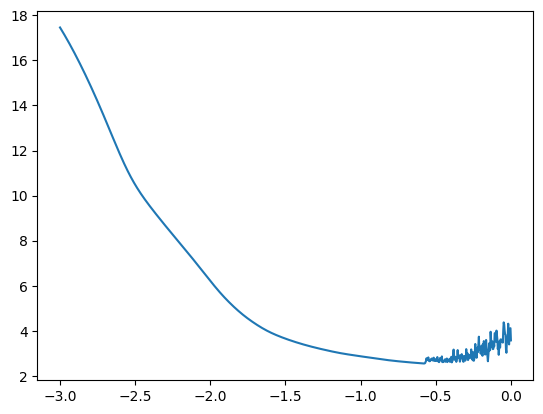

In [21]:
plt.plot(nn2.lri, nn2.losses)

A learning rate betweeen {$10^{-0.9} - 10^{-0.6}$}  looks good. Larger learning rates seems to causes loss fluctuation.

In [38]:
10**-0.9, 10**-0.6

(0.12589254117941673, 0.251188643150958)

#### LR/Loss values for embedding size 10 and hidden dimension size 100.

| LR  |   LOSS  | V.LOSS |
|-----|---------|--------|
| 0.4 | 2.5961  | 2.5995 |
| 0.3 | 2.5965  | 2.6002 |
| 0.2 | 2.5986  | 2.6033 |
| 0.1 | 2.6340  | 2.6388 |

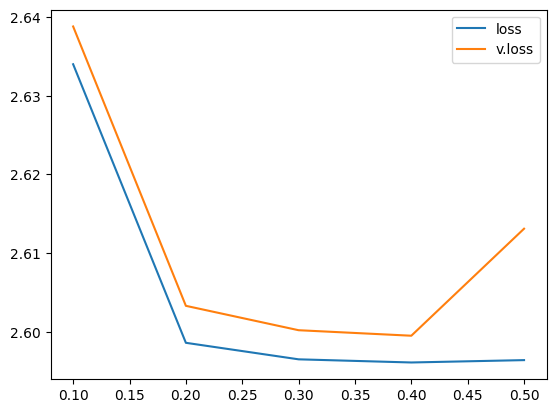

In [32]:
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5], 
         [2.6340, 2.5986, 2.5965, 2.5961, 2.5964], 
         label="loss")
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5], 
         [2.6388, 2.6033, 2.6002, 2.5995, 2.6131 ], 
         label="v.loss")
plt.legend()

In [134]:
%%time

torch.manual_seed(13)
nn2 = MlpLM(1, 2)
nn2.train(xs_train, ys_train, xs_valid, ys_valid, 0.3, 1001)

Model has 3390 parameters!
Using 293606 samples
Step 0 | loss: 17.7242 | val loss: 11.6034
Step 10 | loss: 4.4056 | val loss: 4.2759
Step 20 | loss: 3.5480 | val loss: 3.5363
Step 30 | loss: 3.2801 | val loss: 3.2807
Step 40 | loss: 3.1498 | val loss: 3.1539
Step 50 | loss: 3.0520 | val loss: 3.0553
Step 60 | loss: 2.9779 | val loss: 2.9811
Step 70 | loss: 2.9243 | val loss: 2.9280
Step 80 | loss: 2.8853 | val loss: 2.8893
Step 90 | loss: 2.8554 | val loss: 2.8599
Step 100 | loss: 2.8314 | val loss: 2.8363
Step 110 | loss: 2.8110 | val loss: 2.8166
Step 120 | loss: 2.7926 | val loss: 2.7998
Step 130 | loss: 2.7759 | val loss: 2.7872
Step 140 | loss: 2.7716 | val loss: 2.7844
Step 150 | loss: 2.7719 | val loss: 2.7758
Step 160 | loss: 2.7615 | val loss: 2.7640
Step 170 | loss: 2.7506 | val loss: 2.7531
Step 180 | loss: 2.7407 | val loss: 2.7431
Step 190 | loss: 2.7319 | val loss: 2.7342
Step 200 | loss: 2.7240 | val loss: 2.7261
Step 210 | loss: 2.7168 | val loss: 2.7188
Step 220 | loss

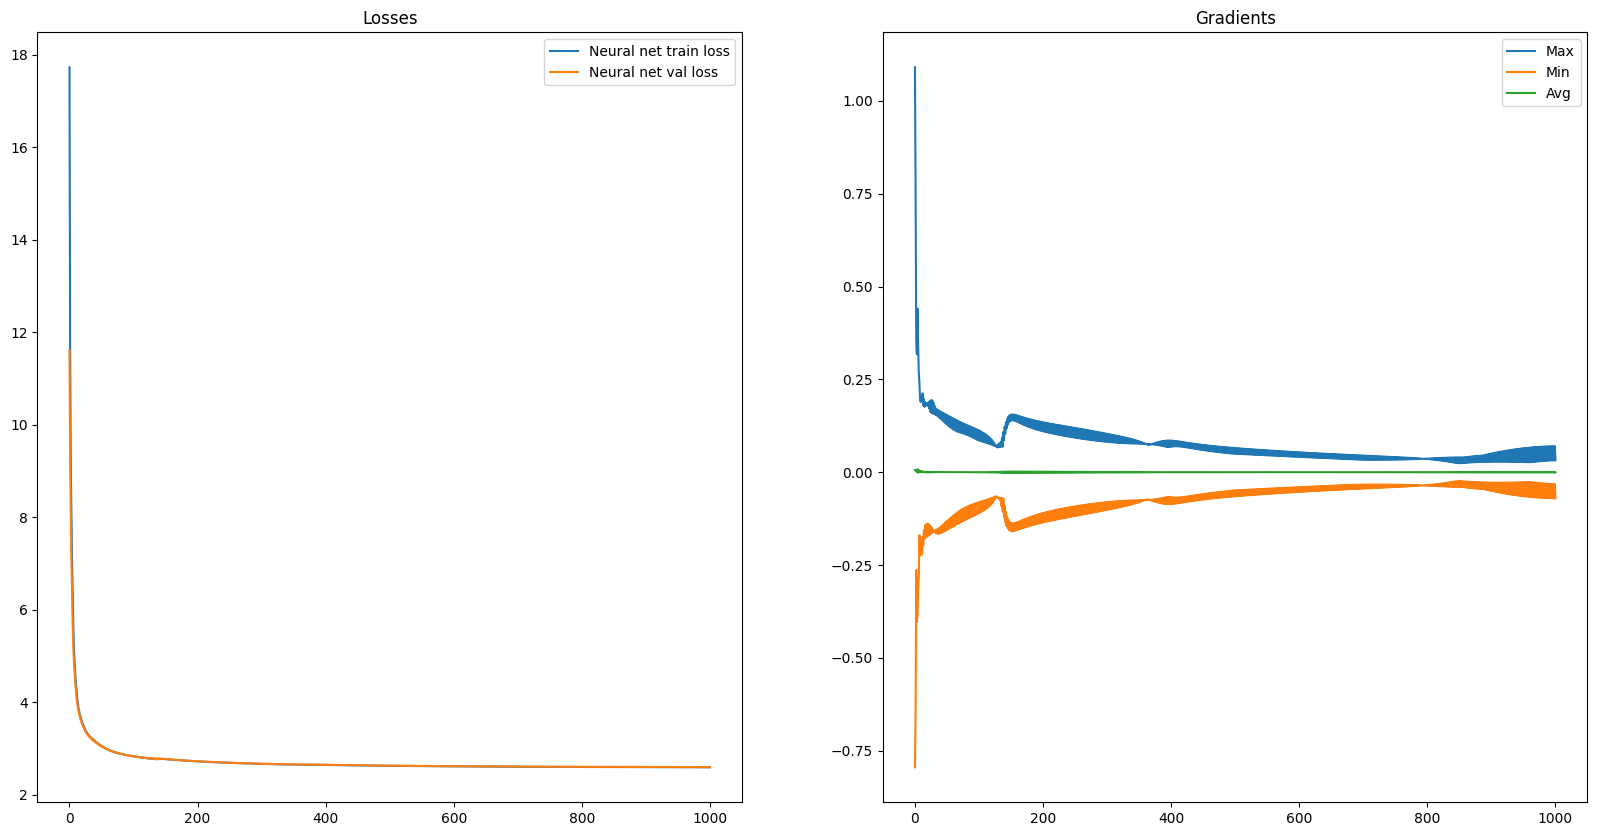

In [135]:
plot_training_loss(nn2)

In [39]:
torch.manual_seed(35)
for i in range(10):
    print(nn2.generate())

igikikak
rmüzsi
srre
tlınbetık
lmatekotgekohık
klayardu
uzmernmemane
tlıziilık
syenazmş
diyınmerletmahazlamüdaksük


### Plot weight updates for bigram model

In [109]:
import os
os.mkdir("w1_images")
os.mkdir("emb_images")

In [129]:
torch.manual_seed(13)
nn2 = MlpLM(1, 2, hidden_size=50)
nn2.train(xs_train, ys_train, None, None, 0.3, 1001, save_fig_frames=True)

Model has 1740 parameters!
Using 293606 samples
Step 0 | loss: 12.9750 | val loss: 0.0000
Step 10 | loss: 4.9174 | val loss: 0.0000
Step 20 | loss: 3.7781 | val loss: 0.0000
Step 30 | loss: 3.3498 | val loss: 0.0000
Step 40 | loss: 3.1745 | val loss: 0.0000
Step 50 | loss: 3.0997 | val loss: 0.0000
Step 60 | loss: 3.0545 | val loss: 0.0000
Step 70 | loss: 3.0213 | val loss: 0.0000
Step 80 | loss: 2.9946 | val loss: 0.0000
Step 90 | loss: 2.9720 | val loss: 0.0000
Step 100 | loss: 2.9518 | val loss: 0.0000
Step 110 | loss: 2.9335 | val loss: 0.0000
Step 120 | loss: 2.9166 | val loss: 0.0000
Step 130 | loss: 2.9006 | val loss: 0.0000
Step 140 | loss: 2.8853 | val loss: 0.0000
Step 150 | loss: 2.8707 | val loss: 0.0000
Step 160 | loss: 2.8569 | val loss: 0.0000
Step 170 | loss: 2.8438 | val loss: 0.0000
Step 180 | loss: 2.8312 | val loss: 0.0000
Step 190 | loss: 2.8190 | val loss: 0.0000
Step 200 | loss: 2.8070 | val loss: 0.0000
Step 210 | loss: 2.7951 | val loss: 0.0000
Step 220 | loss:

In [130]:
import glob

def get_image_files(dir_name):
    pattern = '[0-9][0-9][0-9][0-9].png' 
    filenames = sorted(glob.glob(dir_name +"/"+ pattern))
    return filenames

In [131]:
from PIL import Image

frames = [Image.open(filename) for filename in get_image_files("w1_images")]
first = frames[0]
first.save("5-c1-animation-w1.gif", format="GIF", append_images=frames, save_all=True, fps=10, loop=0)

frames = [Image.open(filename) for filename in get_image_files("emb_images")]
first = frames[0]
first.save("5-c1-animation-emb.gif", format="GIF", append_images=frames, save_all=True, fps=10, loop=0)

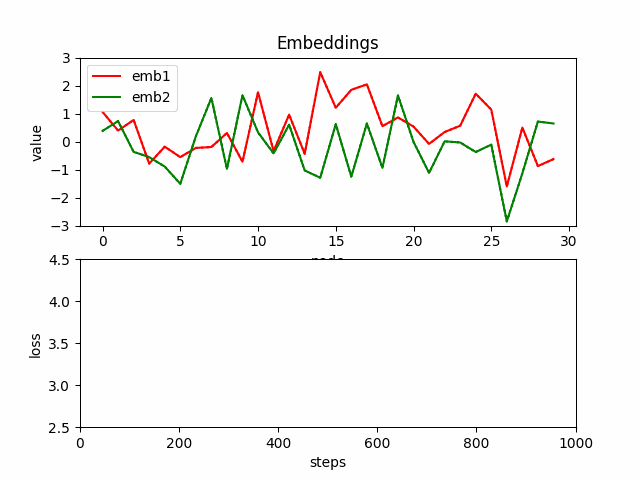

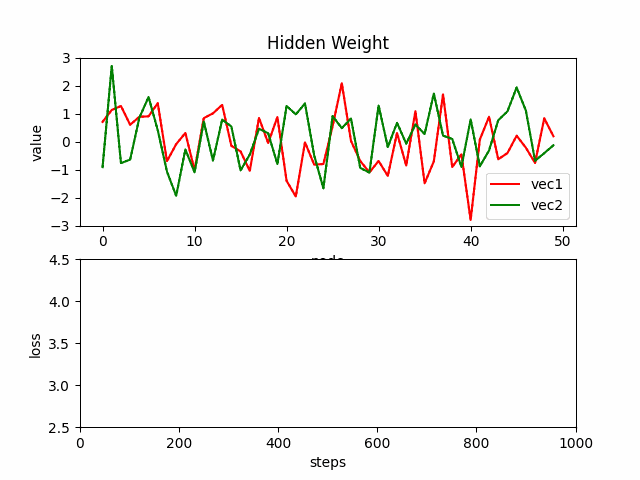

In [133]:
from IPython.display import Image 
display(Image("images/5-c1-animation-emb.gif"))
display(Image("images/5-c1-animation-w1.gif"))

In [381]:
torch.manual_seed(35)
for i in range(10):
    print(nn2_10.generate())

igikikak
rmüzsi
sr
s
tlı
betamülmatakotgeka
çı
klayardu
uhatmememanek
bizilırtaryenazmlıdiyı


## Context Length 2

In [137]:
block_size = 2
xs_train, ys_train = generate_data(words[:n1], block_size)
xs_valid, ys_valid = generate_data(words[n1:n2], block_size)
# xs_test, ys_test = generate_data(words[n2:], block_size)

Generated 293606 samples
Generated 36892 samples


In [138]:
for i in range(10):
    print(decode(list(torch.concat((xs_train[i], ys_train[i,None])).numpy())))

..p
.pa
pan
ant
nte
tei
eiz
izm
zm.
..f


### Find a good learning rate

In [139]:
%%time

torch.manual_seed(13)
nn3_10 = MlpLM(2, 10, hidden_size=200)
nn3_10.train(xs_train, ys_train, None, None, None, 1001)

Model has 10530 parameters!
Using 293606 samples


Step 0 | loss: 26.5698 | val loss: 0.0000
Step 10 | loss: 26.0601 | val loss: 0.0000
Step 20 | loss: 25.6376 | val loss: 0.0000
Step 30 | loss: 25.4288 | val loss: 0.0000
Step 40 | loss: 25.2283 | val loss: 0.0000
Step 50 | loss: 25.0232 | val loss: 0.0000
Step 60 | loss: 24.8141 | val loss: 0.0000
Step 70 | loss: 24.6007 | val loss: 0.0000
Step 80 | loss: 24.3814 | val loss: 0.0000
Step 90 | loss: 24.1556 | val loss: 0.0000
Step 100 | loss: 23.9209 | val loss: 0.0000
Step 110 | loss: 23.6771 | val loss: 0.0000
Step 120 | loss: 23.4228 | val loss: 0.0000
Step 130 | loss: 23.1579 | val loss: 0.0000
Step 140 | loss: 22.8821 | val loss: 0.0000
Step 150 | loss: 22.5962 | val loss: 0.0000
Step 160 | loss: 22.3013 | val loss: 0.0000
Step 170 | loss: 21.9977 | val loss: 0.0000
Step 180 | loss: 21.6849 | val loss: 0.0000
Step 190 | loss: 21.3627 | val loss: 0.0000
Step 200 | loss: 21.0314 | val loss: 0.0000
Step 210 | loss: 20.6925 | val loss: 0.0000
Step 220 | loss: 20.3467 | val loss: 0.0000

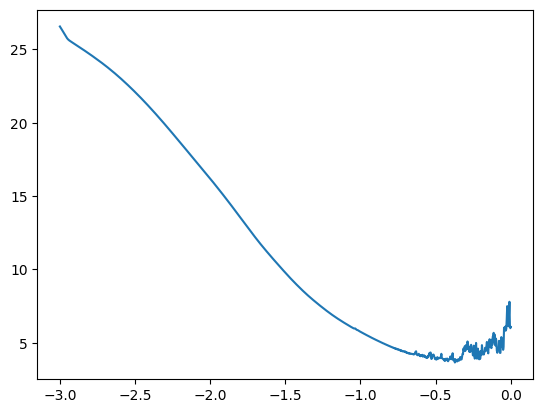

In [140]:
plt.plot(nn3_10.lri, nn3_10.losses)

A learning rate betweeen {$10^{-0.5} - 10^{-0.4}$}  looks good. Larger learning rates seems to causes loss fluctuation.

In [155]:
10**-0.5, 10**-0.4

(0.31622776601683794, 0.3981071705534972)

#### LR/Loss values for embedding size 10 and hidden dimension size 200.

| LR  |   LOSS  | V.LOSS |
|-----|---------|--------|
| 0.7 | 2.4933  | 2.6044 |
| 0.6 | 2.5110  | 2.5010 |
| **0.5** | **2.4867**  | **2.4949** |
| 0.4 | 2.5088  | 2.5216 |
| 0.3 | 2.5514  | 2.5920 |
| 0.2 | 2.5883  | 2.6036 |
| 0.1 | 2.9372  | 2.9458 |

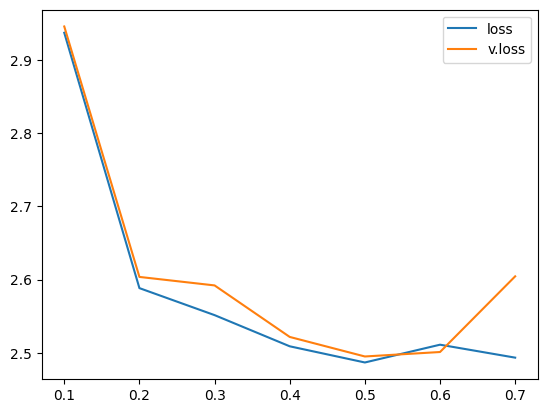

In [153]:
plt.plot([0.1, 0.2,0.3,0.4,0.5,0.6,0.7], [2.9372, 2.5883, 2.5514, 2.5088, 2.4867, 2.5110, 2.4933], label="loss")
plt.plot([0.1, 0.2,0.3,0.4,0.5,0.6,0.7], [2.9458, 2.6036, 2.5920, 2.5216, 2.4949, 2.5010, 2.6044], label="v.loss")
plt.legend()
plt.show()

In [159]:
%%time

torch.manual_seed(13)
nn3_10_4 = MlpLM(2, 10, hidden_size=200)
nn3_10_4.train(xs_train, ys_train, xs_valid, ys_valid, 0.5, 1001)

Model has 10530 parameters!
Using 293606 samples
Step 0 | loss: 26.5698 | val loss: 23.2395
Step 10 | loss: 10.5712 | val loss: 10.3443
Step 20 | loss: 7.3860 | val loss: 7.2998
Step 30 | loss: 5.9236 | val loss: 6.0198
Step 40 | loss: 5.2258 | val loss: 5.3938
Step 50 | loss: 4.8773 | val loss: 4.9680
Step 60 | loss: 4.5284 | val loss: 4.5072
Step 70 | loss: 4.3282 | val loss: 4.4810
Step 80 | loss: 4.2793 | val loss: 4.1458
Step 90 | loss: 3.9709 | val loss: 4.0609
Step 100 | loss: 3.9163 | val loss: 3.7371
Step 110 | loss: 3.7407 | val loss: 3.7678
Step 120 | loss: 3.7472 | val loss: 3.6339
Step 130 | loss: 3.5749 | val loss: 3.6139
Step 140 | loss: 3.5210 | val loss: 3.4235
Step 150 | loss: 3.4696 | val loss: 3.4483
Step 160 | loss: 3.4191 | val loss: 3.3873
Step 170 | loss: 3.3798 | val loss: 3.3139
Step 180 | loss: 3.3459 | val loss: 3.2909
Step 190 | loss: 3.2598 | val loss: 3.2471
Step 200 | loss: 3.2319 | val loss: 3.2143
Step 210 | loss: 3.2010 | val loss: 3.1904
Step 220 | l

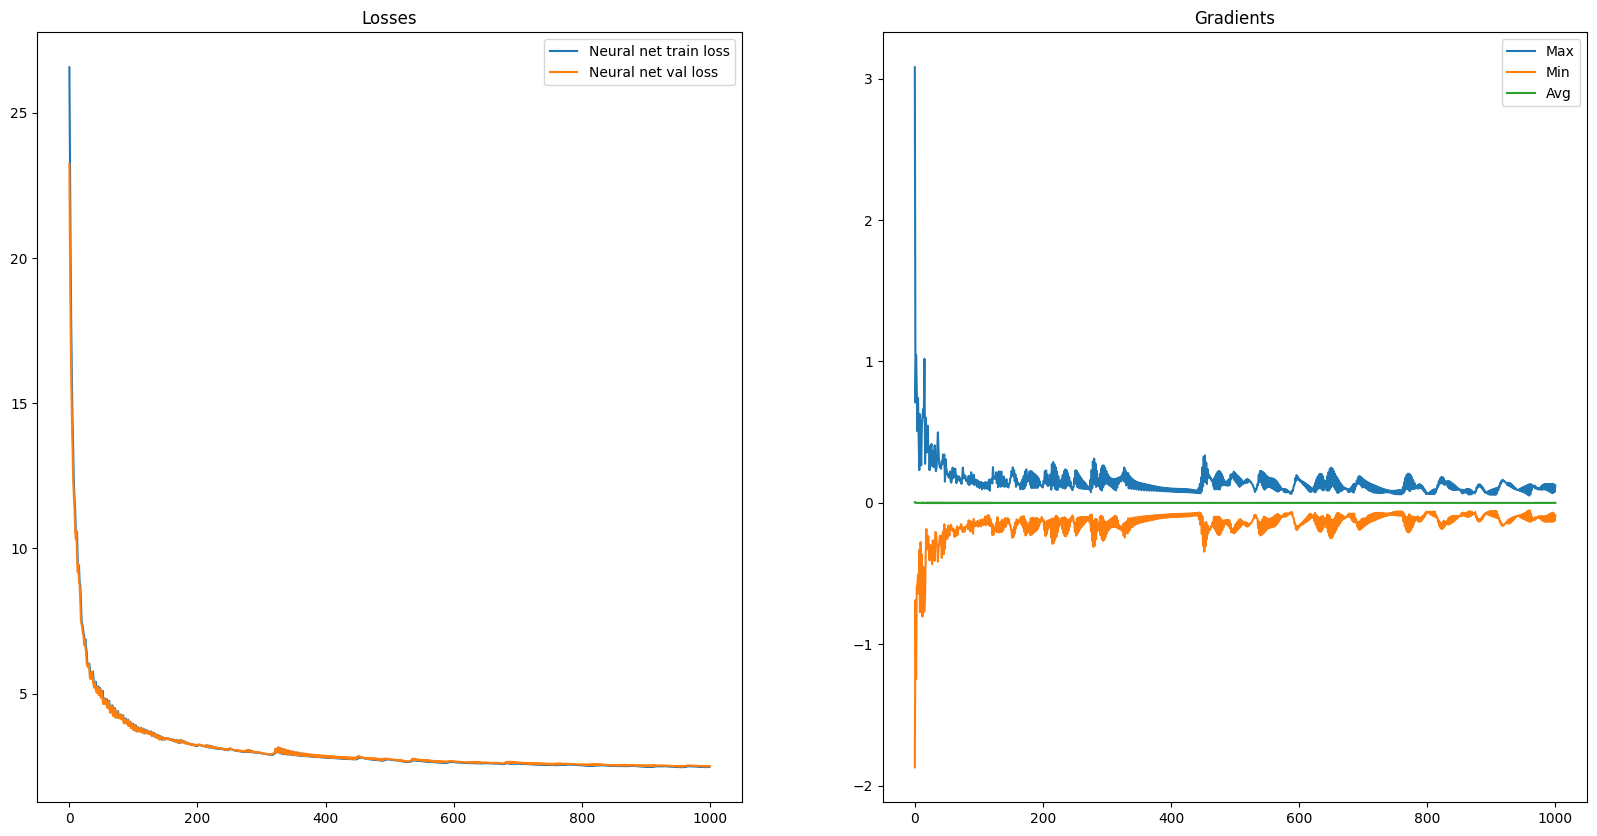

In [160]:
plot_training_loss(nn3_10_4)

In [161]:
torch.manual_seed(35)
for i in range(10):
    print(nn3_10_4.generate())

ig
kobik
rohası
sris
tatabetkillenekaragzürı
hayık
sek
muhatmek
maklüklamiklak
savlaştırdiysununletmahazlamakalsik


## Context Length 3

In [162]:
block_size = 3
xs_train, ys_train = generate_data(words[:n1], block_size)
xs_valid, ys_valid = generate_data(words[n1:n2], block_size)
# xs_test, ys_test = generate_data(words[n2:], block_size)

Generated 293606 samples
Generated 36892 samples


In [163]:
for i in range(10):
    print(decode(list(torch.concat((xs_train[i], ys_train[i,None])).numpy())))

...p
..pa
.pan
pant
ante
ntei
teiz
eizm
izm.
...f


In [164]:
%%time

torch.manual_seed(13)
nn4_lr_test = MlpLM(3, 10, hidden_size=200)
nn4_lr_test.train(xs_train[:1000], ys_train[:1000], None, None, None, 1001)

Model has 12530 parameters!
Using 1000 samples
Step 0 | loss: 25.9211 | val loss: 0.0000
Step 10 | loss: 25.7418 | val loss: 0.0000
Step 20 | loss: 25.5617 | val loss: 0.0000
Step 30 | loss: 25.3859 | val loss: 0.0000
Step 40 | loss: 25.2151 | val loss: 0.0000
Step 50 | loss: 25.0429 | val loss: 0.0000
Step 60 | loss: 24.8645 | val loss: 0.0000
Step 70 | loss: 24.6773 | val loss: 0.0000
Step 80 | loss: 24.4802 | val loss: 0.0000
Step 90 | loss: 24.2731 | val loss: 0.0000
Step 100 | loss: 24.0565 | val loss: 0.0000
Step 110 | loss: 23.8314 | val loss: 0.0000
Step 120 | loss: 23.5994 | val loss: 0.0000
Step 130 | loss: 23.3637 | val loss: 0.0000
Step 140 | loss: 23.1292 | val loss: 0.0000
Step 150 | loss: 22.8994 | val loss: 0.0000
Step 160 | loss: 22.6718 | val loss: 0.0000
Step 170 | loss: 22.4421 | val loss: 0.0000
Step 180 | loss: 22.2071 | val loss: 0.0000
Step 190 | loss: 21.9650 | val loss: 0.0000
Step 200 | loss: 21.7141 | val loss: 0.0000
Step 210 | loss: 21.4525 | val loss: 0.0

### Find a good learning rate

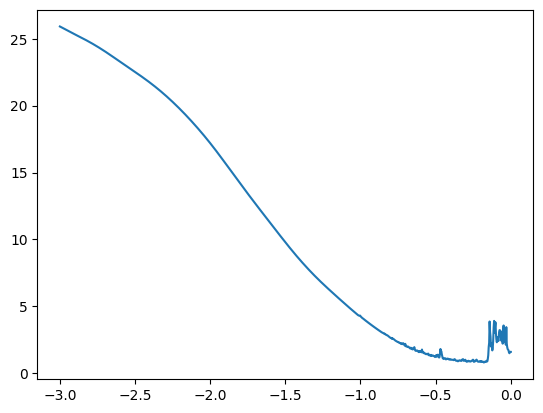

In [165]:
plt.plot(nn4_lr_test.lri, nn4_lr_test.losses)

In [180]:
10**-0.5, 10**-0.2

(0.31622776601683794, 0.6309573444801932)

#### LR/Loss values for embedding size 10 and hidden dimension size 200.

| LR  |   LOSS  | V.LOSS |
|-----|---------|--------|
| 0.8 | 2.6891  | 2.8221 |
| 0.7 | 2.4815  | 2.6060 |
| **0.6** | **2.5761**  | **2.5496** |
| 0.5 | 2.5949  | 2.5707 |
| 0.4 | 2.5798  | 2.6218 |
| 0.3 | 2.5907  | 2.5667 |
| 0.2 | 2.6263  | 2.6503 |
| 0.1 | 3.0258  | 3.0637 |

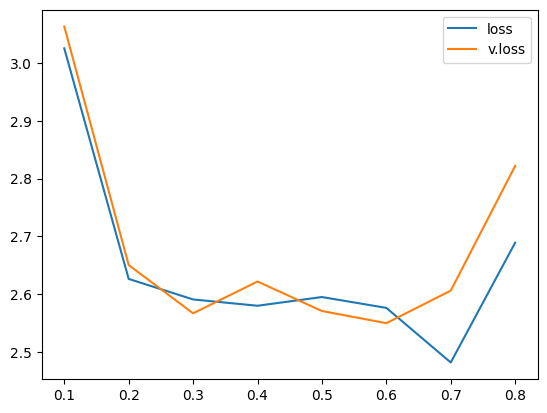

In [177]:
plt.plot([0.1, 0.2,0.3,0.4,0.5,0.6,0.7, 0.8], [3.0258, 2.6263, 2.5907, 2.5798, 2.5949, 2.5761, 2.4815, 2.6891], label="loss")
plt.plot([0.1, 0.2,0.3,0.4,0.5,0.6,0.7, 0.8], [3.0637, 2.6503, 2.5667, 2.6218, 2.5707, 2.5496, 2.6060, 2.8221], label="v.loss")
plt.legend()
plt.show()

In [181]:
%%time

torch.manual_seed(13)
nn4 = MlpLM(3, 10, hidden_size=200)
nn4.train(xs_train, ys_train, xs_valid, ys_valid, 0.6, 1001)

Model has 12530 parameters!
Using 293606 samples
Step 0 | loss: 26.1091 | val loss: 23.2980
Step 10 | loss: 12.8254 | val loss: 12.7734
Step 20 | loss: 9.2633 | val loss: 8.8566
Step 30 | loss: 7.5457 | val loss: 7.3096
Step 40 | loss: 6.6454 | val loss: 6.7175
Step 50 | loss: 5.9471 | val loss: 6.1408
Step 60 | loss: 5.5987 | val loss: 5.6858
Step 70 | loss: 5.4462 | val loss: 5.7174
Step 80 | loss: 5.3738 | val loss: 5.1155
Step 90 | loss: 4.7339 | val loss: 4.9495
Step 100 | loss: 4.6903 | val loss: 4.8158
Step 110 | loss: 4.4957 | val loss: 4.8652
Step 120 | loss: 4.3384 | val loss: 4.4154
Step 130 | loss: 4.3457 | val loss: 4.4788
Step 140 | loss: 4.1967 | val loss: 4.0798
Step 150 | loss: 4.1606 | val loss: 4.3664
Step 160 | loss: 4.0011 | val loss: 4.3018
Step 170 | loss: 3.8780 | val loss: 4.0679
Step 180 | loss: 3.7677 | val loss: 4.1579
Step 190 | loss: 3.8905 | val loss: 3.8009
Step 200 | loss: 3.6538 | val loss: 3.8344
Step 210 | loss: 3.6316 | val loss: 3.5179
Step 220 | l

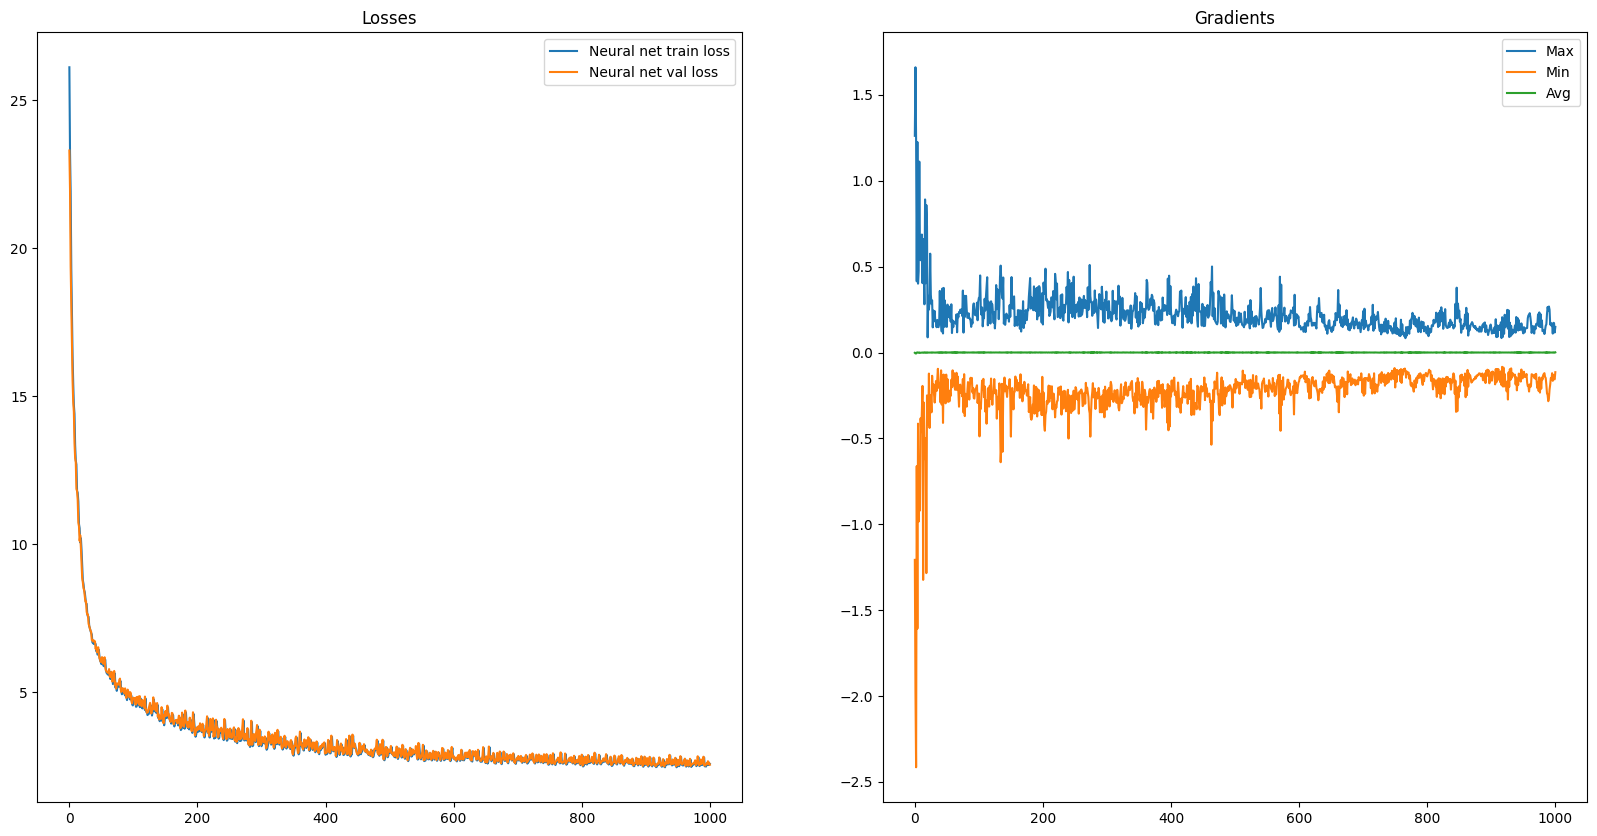

In [182]:
plot_training_loss(nn4)